In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
# -----------------------------
# Setting up Base directory and Working directory path
# -----------------------------

# Chemin vers le dataset
Base_dir = '/content/gdrive/MyDrive/Imagetest/dataset8K'

# Chemin vers le dossier de sauvegarde
working_dir = '/content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie'
os.makedirs(working_dir, exist_ok=True)

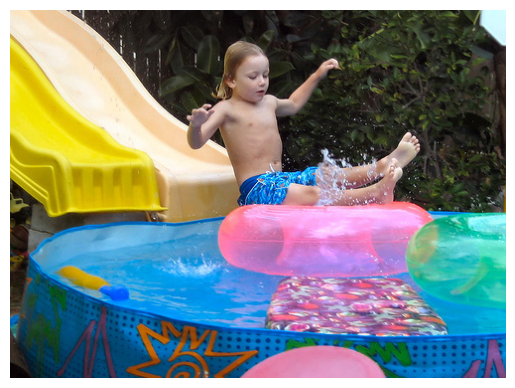

In [ ]:
# Exemple d'affichage d'une image depuis ton dataset Drive
image_name = "1077546505_a4f6c4daa9.jpg"
image_id = image_name.split('.')[0]

# Construction du chemin complet vers l'image
img_path = os.path.join(Base_dir, "Images", image_name)

# Ouverture et affichage de l'image
image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')  # pour cacher les axes (optionnel)
plt.show()


In [ ]:
# Chargement du fichier captions.txt depuis ton Drive
data = pd.read_csv(os.path.join(Base_dir, "captions.txt"))

data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# 2- Image Feature Extraction 🖼️🔍
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
##################################################
##################################################
##################################################
##################################################
##################################################

In [ ]:
# -----------------------------------------
# 3) Extraction et sauvegarde des features
# -----------------------------------------

# Dictionnaire pour stocker les features
#features = {}

# Dossier contenant les images
#directory = os.path.join(Base_dir, 'Images')

# Parcours de toutes les images
# for img_name in tqdm(os.listdir(directory)):
#     img_path = os.path.join(directory, img_name)

#     # Chargement + prétraitement
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
#     image = preprocess_input(image)

    # Extraction des features via VGG16
    # feature = model.predict(image, verbose=0)

    # # Enregistrement dans le dictionnaire
    # image_id = img_name.split('.')[0]
    # features[image_id] = feature

# -----------------------------------------
# Sauvegarde dans un fichier .pkl
# -----------------------------------------
# features_path = os.path.join(working_dir, "features.pkl")

# with open(features_path, "wb") as f:
#     pickle.dump(features, f)

# print("✔️ Features sauvegardées dans :", features_path)


In [ ]:
##################################################
##################################################
##################################################
##################################################
##################################################

In [ ]:
# 3 - Text Preprocessing ✏️🧹

captions_path = os.path.join(Base_dir, 'captions.txt')

with open(captions_path, 'r') as File:
    next(File)  # saute la première ligne
    captions_file = File.read()


In [ ]:
# -----------------------------------------
# Création du dictionnaire mapping image_id -> captions
# -----------------------------------------
mapping = {}

for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')

    # Ignore les lignes vides ou trop courtes
    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

# -----------------------------------------
# Sauvegarde du mapping dans un fichier .pkl
# -----------------------------------------
mapping_path = os.path.join(working_dir, "captions_mapping.pkl")

with open(mapping_path, "wb") as f:
    pickle.dump(mapping, f)

print("✔️ Mapping captions sauvegardé dans :", mapping_path)


  0%|          | 0/40456 [00:00<?, ?it/s]

✔️ Mapping captions sauvegardé dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/captions_mapping.pkl


In [ ]:
# -----------------------------
# Text preprocessing function
# -----------------------------
def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            # Retirer les caractères non alphabétiques
            caption = ''.join([c if c.isalpha() or c.isspace() else '' for c in caption])
            # Remplacer les espaces multiples par un seul
            caption = ' '.join(caption.split())
            # Ajouter startseq et endseq et enlever les mots d'une lettre
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

# Exécution du preprocessing
preprocessing(mapping)

# -----------------------------
# Sauvegarde du mapping preprocessé
# -----------------------------
preprocessed_mapping_path = os.path.join(working_dir, "captions_mapping_preprocessed.pkl")

with open(preprocessed_mapping_path, "wb") as f:
    pickle.dump(mapping, f)

print("✔️ Mapping captions preprocessé sauvegardé dans :", preprocessed_mapping_path)


✔️ Mapping captions preprocessé sauvegardé dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/captions_mapping_preprocessed.pkl


In [ ]:
# -----------------------------
# 4 - Tokenization and Splitting 📝🔡
# -----------------------------

# Extraction de toutes les captions en une seule liste
all_captions = [caption for key in mapping for caption in mapping[key]]

# Affichage de quelques captions pour vérification
print(all_captions[:5])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# -----------------------------
# 5 - Tokenizer & Vocabulary
# -----------------------------
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Taille du vocabulaire
vocab_size = len(tokenizer.word_index) + 1

# Longueur maximale d'une caption
max_length = max(len(caption.split()) for caption in all_captions)

print("Vocab size :", vocab_size)
print("Max caption length :", max_length)

# -----------------------------
# Sauvegarde tokenizer et infos dans .pkl
# -----------------------------
tokenizer_path = os.path.join(working_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

metadata = {"vocab_size": vocab_size, "max_length": max_length}
metadata_path = os.path.join(working_dir, "metadata.pkl")
with open(metadata_path, "wb") as f:
    pickle.dump(metadata, f)

print("✔️ Tokenizer et metadata sauvegardés dans :", working_dir)


Vocab size : 8768
Max caption length : 34
✔️ Tokenizer et metadata sauvegardés dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie


In [ ]:
from sklearn.model_selection import train_test_split

# -----------------------------
# 5 - Splitting data into train and test ✂️📊
# -----------------------------

# Récupération des IDs des images
image_ids = list(mapping.keys())

# Split en train (90%) et test (10%)
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

# -----------------------------
# Sauvegarde des splits
# -----------------------------
train_path = os.path.join(working_dir, "train_ids.pkl")
test_path  = os.path.join(working_dir, "test_ids.pkl")

with open(train_path, "wb") as f:
    pickle.dump(train, f)

with open(test_path, "wb") as f:
    pickle.dump(test, f)

print("✔️ Train/Test IDs sauvegardés dans :", working_dir)


✔️ Train/Test IDs sauvegardés dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie


In [ ]:
# 6. Data Generation (To Avoid Memory Issues) 🔄📦
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                # Convertir la caption en séquence d'entiers
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # ✅ padding à droite pour compatibilité avec CuDNN
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()
                X2.clear()
                y.clear()
                n = 0


In [ ]:
# 7 - Model Architecture 🏗️

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# --- Image feature branch ---
inputs1 = Input(shape=(4096,), name="image")
x1 = Dropout(0.4)(inputs1)
x1 = Dense(512, activation='relu')(x1)

# --- Sequence feature branch ---
inputs2 = Input(shape=(max_length,), name="text")
x2 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
x2 = Dropout(0.4)(x2)
x2 = LSTM(512)(x2)  # LSTM compatible avec padding='post'

# --- Merge & output ---
decoder1 = add([x1, x2])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 34)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 512)   │  4,489,216 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 34, 512)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 34)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  2,097,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 512)       │  2,099,200 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 512)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8768)      │  4,497,984 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,446,720 (51.30 MB)

 Trainable params: 13,446,720 (51.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model
import os

model_plot_path = os.path.join(working_dir, "model.png")

plot_model(
    model,
    to_file=model_plot_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

print("✔️ Schéma du modèle sauvegardé dans :", model_plot_path)


✔️ Schéma du modèle sauvegardé dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/model.png


In [ ]:
import pickle
import os

# Chemin vers le fichier .pkl contenant les features
features_path = os.path.join(working_dir, "features.pkl")

# Charger les features
with open(features_path, "rb") as f:
    features = pickle.load(f)

print("✔️ Features chargées :", len(features), "images")


✔️ Features chargées : 8091 images


In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np

epochs = 120
batch_size = 64
steps = len(train) // batch_size

checkpoint_path = os.path.join(working_dir, "best_model.h5")
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5)
early_stop = EarlyStopping(monitor='loss', patience=7, verbose=1, restore_best_weights=True)

np.random.shuffle(train)
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

model.fit(
    generator,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

print("✔️ Entraînement terminé. Meilleur modèle sauvegardé dans :", checkpoint_path)


Epoch 1/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 5.9193
Epoch 1: loss improved from inf to 5.23751, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 521ms/step - loss: 5.9133 - learning_rate: 0.0010
Epoch 2/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 4.1046
Epoch 2: loss improved from 5.23751 to 3.92878, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 537ms/step - loss: 4.1030 - learning_rate: 0.0010
Epoch 3/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 3.5466
Epoch 3: loss improved from 3.92878 to 3.45255, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - loss: 3.5458 - learning_rate: 0.0010
Epoch 4/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 3.2127
Epoch 4: loss improved from 3.45255 to 3.14892, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 560ms/step - loss: 3.2122 - learning_rate: 0.0010
Epoch 5/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 2.9653
Epoch 5: loss improved from 3.14892 to 2.92107, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - loss: 2.9649 - learning_rate: 0.0010
Epoch 6/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 2.7893
Epoch 6: loss improved from 2.92107 to 2.75434, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 553ms/step - loss: 2.7890 - learning_rate: 0.0010
Epoch 7/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 2.6481
Epoch 7: loss improved from 2.75434 to 2.62344, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 561ms/step - loss: 2.6479 - learning_rate: 0.0010
Epoch 8/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 2.5344
Epoch 8: loss improved from 2.62344 to 2.51605, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 2.5342 - learning_rate: 0.0010
Epoch 9/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 2.4345
Epoch 9: loss improved from 2.51605 to 2.42035, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - loss: 2.4344 - learning_rate: 0.0010
Epoch 10/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 2.3499
Epoch 10: loss improved from 2.42035 to 2.33605, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 571ms/step - loss: 2.3497 - learning_rate: 0.0010
Epoch 11/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 2.2705
Epoch 11: loss improved from 2.33605 to 2.26295, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - loss: 2.2704 - learning_rate: 0.0010
Epoch 12/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 2.1967
Epoch 12: loss improved from 2.26295 to 2.18808, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 554ms/step - loss: 2.1967 - learning_rate: 0.0010
Epoch 13/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 2.1317
Epoch 13: loss improved from 2.18808 to 2.12589, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - loss: 2.1317 - learning_rate: 0.0010
Epoch 14/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 2.0770
Epoch 14: loss improved from 2.12589 to 2.06711, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 556ms/step - loss: 2.0769 - learning_rate: 0.0010
Epoch 15/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 2.0116
Epoch 15: loss improved from 2.06711 to 2.00585, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 578ms/step - loss: 2.0116 - learning_rate: 0.0010
Epoch 16/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 1.9567
Epoch 16: loss improved from 2.00585 to 1.95280, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 1.9567 - learning_rate: 0.0010
Epoch 17/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 1.9011
Epoch 17: loss improved from 1.95280 to 1.90400, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 1.9012 - learning_rate: 0.0010
Epoch 18/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 1.8591
Epoch 18: loss improved from 1.90400 to 1.85816, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 553ms/step - loss: 1.8591 - learning_rate: 0.0010
Epoch 19/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.8199
Epoch 19: loss improved from 1.85816 to 1.81460, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 594ms/step - loss: 1.8199 - learning_rate: 0.0010
Epoch 20/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 1.7847
Epoch 20: loss improved from 1.81460 to 1.77748, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - loss: 1.7846 - learning_rate: 0.0010
Epoch 21/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 1.7529
Epoch 21: loss improved from 1.77748 to 1.74808, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 559ms/step - loss: 1.7529 - learning_rate: 0.0010
Epoch 22/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 1.7127
Epoch 22: loss improved from 1.74808 to 1.70796, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 596ms/step - loss: 1.7127 - learning_rate: 0.0010
Epoch 23/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 1.6720
Epoch 23: loss improved from 1.70796 to 1.66602, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 581ms/step - loss: 1.6719 - learning_rate: 0.0010
Epoch 24/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 1.6334
Epoch 24: loss improved from 1.66602 to 1.62708, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - loss: 1.6334 - learning_rate: 0.0010
Epoch 25/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 1.6039
Epoch 25: loss improved from 1.62708 to 1.59535, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 1.6039 - learning_rate: 0.0010
Epoch 26/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.5700
Epoch 26: loss improved from 1.59535 to 1.56497, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 1.5700 - learning_rate: 0.0010
Epoch 27/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 1.5457
Epoch 27: loss improved from 1.56497 to 1.54154, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 1.5456 - learning_rate: 0.0010
Epoch 28/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 1.5228
Epoch 28: loss improved from 1.54154 to 1.51712, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 579ms/step - loss: 1.5227 - learning_rate: 0.0010
Epoch 29/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 1.4983
Epoch 29: loss improved from 1.51712 to 1.48977, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - loss: 1.4982 - learning_rate: 0.0010
Epoch 30/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 1.4754
Epoch 30: loss improved from 1.48977 to 1.46278, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - loss: 1.4753 - learning_rate: 0.0010
Epoch 31/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 1.4495
Epoch 31: loss improved from 1.46278 to 1.43783, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 577ms/step - loss: 1.4494 - learning_rate: 0.0010
Epoch 32/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.4278
Epoch 32: loss improved from 1.43783 to 1.41458, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - loss: 1.4276 - learning_rate: 0.0010
Epoch 33/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.3976
Epoch 33: loss improved from 1.41458 to 1.38459, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 545ms/step - loss: 1.3975 - learning_rate: 0.0010
Epoch 34/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.3724
Epoch 34: loss improved from 1.38459 to 1.35840, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 1.3723 - learning_rate: 0.0010
Epoch 35/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.3450
Epoch 35: loss improved from 1.35840 to 1.32555, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 1.3448 - learning_rate: 0.0010
Epoch 36/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.3201
Epoch 36: loss improved from 1.32555 to 1.30019, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 601ms/step - loss: 1.3199 - learning_rate: 0.0010
Epoch 37/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.2906
Epoch 37: loss improved from 1.30019 to 1.27163, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 591ms/step - loss: 1.2904 - learning_rate: 0.0010
Epoch 38/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.2596
Epoch 38: loss improved from 1.27163 to 1.24743, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 574ms/step - loss: 1.2595 - learning_rate: 0.0010
Epoch 39/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.2395
Epoch 39: loss improved from 1.24743 to 1.22554, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 587ms/step - loss: 1.2394 - learning_rate: 0.0010
Epoch 40/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.2191
Epoch 40: loss improved from 1.22554 to 1.20604, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 1.2190 - learning_rate: 0.0010
Epoch 41/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.1973
Epoch 41: loss improved from 1.20604 to 1.18386, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 579ms/step - loss: 1.1972 - learning_rate: 0.0010
Epoch 42/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.1785
Epoch 42: loss improved from 1.18386 to 1.16840, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - loss: 1.1784 - learning_rate: 0.0010
Epoch 43/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.1656
Epoch 43: loss improved from 1.16840 to 1.15456, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - loss: 1.1655 - learning_rate: 0.0010
Epoch 44/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.1483
Epoch 44: loss improved from 1.15456 to 1.13883, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 578ms/step - loss: 1.1483 - learning_rate: 0.0010
Epoch 45/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.1302
Epoch 45: loss improved from 1.13883 to 1.12376, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - loss: 1.1301 - learning_rate: 0.0010
Epoch 46/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.1169
Epoch 46: loss improved from 1.12376 to 1.10936, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 555ms/step - loss: 1.1168 - learning_rate: 0.0010
Epoch 47/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.1008
Epoch 47: loss improved from 1.10936 to 1.09626, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 563ms/step - loss: 1.1007 - learning_rate: 0.0010
Epoch 48/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.0988
Epoch 48: loss improved from 1.09626 to 1.08953, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 573ms/step - loss: 1.0987 - learning_rate: 0.0010
Epoch 49/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 1.0930
Epoch 49: loss improved from 1.08953 to 1.08250, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 563ms/step - loss: 1.0929 - learning_rate: 0.0010
Epoch 50/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.0870
Epoch 50: loss improved from 1.08250 to 1.07651, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 584ms/step - loss: 1.0869 - learning_rate: 0.0010
Epoch 51/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1.0737
Epoch 51: loss improved from 1.07651 to 1.06060, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 1.0736 - learning_rate: 0.0010
Epoch 52/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 1.0604
Epoch 52: loss improved from 1.06060 to 1.04780, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 565ms/step - loss: 1.0603 - learning_rate: 0.0010
Epoch 53/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.0425
Epoch 53: loss improved from 1.04780 to 1.03087, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 565ms/step - loss: 1.0424 - learning_rate: 0.0010
Epoch 54/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 1.0285
Epoch 54: loss improved from 1.03087 to 1.01425, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - loss: 1.0283 - learning_rate: 0.0010
Epoch 55/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.0060
Epoch 55: loss improved from 1.01425 to 0.99536, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 594ms/step - loss: 1.0059 - learning_rate: 0.0010
Epoch 56/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.9867
Epoch 56: loss improved from 0.99536 to 0.97881, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - loss: 0.9866 - learning_rate: 0.0010
Epoch 57/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.9692
Epoch 57: loss improved from 0.97881 to 0.96302, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 564ms/step - loss: 0.9691 - learning_rate: 0.0010
Epoch 58/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.9509
Epoch 58: loss improved from 0.96302 to 0.95272, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 619ms/step - loss: 0.9510 - learning_rate: 0.0010
Epoch 59/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.9370
Epoch 59: loss improved from 0.95272 to 0.93674, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 0.9370 - learning_rate: 0.0010
Epoch 60/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.9282
Epoch 60: loss improved from 0.93674 to 0.92552, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - loss: 0.9282 - learning_rate: 0.0010
Epoch 61/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.9183
Epoch 61: loss improved from 0.92552 to 0.91335, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 562ms/step - loss: 0.9183 - learning_rate: 0.0010
Epoch 62/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 0.9131
Epoch 62: loss improved from 0.91335 to 0.90463, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 556ms/step - loss: 0.9131 - learning_rate: 0.0010
Epoch 63/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.9013
Epoch 63: loss improved from 0.90463 to 0.89147, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 569ms/step - loss: 0.9012 - learning_rate: 0.0010
Epoch 64/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.8892
Epoch 64: loss improved from 0.89147 to 0.88146, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 596ms/step - loss: 0.8892 - learning_rate: 0.0010
Epoch 65/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 0.8775
Epoch 65: loss improved from 0.88146 to 0.86854, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 560ms/step - loss: 0.8775 - learning_rate: 0.0010
Epoch 66/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.8735
Epoch 66: loss improved from 0.86854 to 0.86218, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 577ms/step - loss: 0.8734 - learning_rate: 0.0010
Epoch 67/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.8583
Epoch 67: loss improved from 0.86218 to 0.84932, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.8582 - learning_rate: 0.0010
Epoch 68/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.8456
Epoch 68: loss improved from 0.84932 to 0.84109, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 0.8455 - learning_rate: 0.0010
Epoch 69/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.8381
Epoch 69: loss improved from 0.84109 to 0.83319, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - loss: 0.8381 - learning_rate: 0.0010
Epoch 70/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.8298
Epoch 70: loss improved from 0.83319 to 0.82691, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - loss: 0.8298 - learning_rate: 0.0010
Epoch 71/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 0.8188
Epoch 71: loss improved from 0.82691 to 0.81626, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 598ms/step - loss: 0.8188 - learning_rate: 0.0010
Epoch 72/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.8073
Epoch 72: loss improved from 0.81626 to 0.80707, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 0.8073 - learning_rate: 0.0010
Epoch 73/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.8027
Epoch 73: loss improved from 0.80707 to 0.80380, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 0.8027 - learning_rate: 0.0010
Epoch 74/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 0.7989
Epoch 74: loss improved from 0.80380 to 0.79919, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - loss: 0.7989 - learning_rate: 0.0010
Epoch 75/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.7900
Epoch 75: loss improved from 0.79919 to 0.79221, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 573ms/step - loss: 0.7900 - learning_rate: 0.0010
Epoch 76/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.7897
Epoch 76: loss improved from 0.79221 to 0.79176, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - loss: 0.7897 - learning_rate: 0.0010
Epoch 77/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.7835
Epoch 77: loss improved from 0.79176 to 0.78189, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 67s 599ms/step - loss: 0.7835 - learning_rate: 0.0010
Epoch 78/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.7760
Epoch 78: loss improved from 0.78189 to 0.77565, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - loss: 0.7760 - learning_rate: 0.0010
Epoch 79/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.7706
Epoch 79: loss improved from 0.77565 to 0.76930, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.7706 - learning_rate: 0.0010
Epoch 80/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 0.7661
Epoch 80: loss improved from 0.76930 to 0.76035, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - loss: 0.7661 - learning_rate: 0.0010
Epoch 81/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.7607
Epoch 81: loss improved from 0.76035 to 0.75092, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.7606 - learning_rate: 0.0010
Epoch 82/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.7576
Epoch 82: loss improved from 0.75092 to 0.74566, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 580ms/step - loss: 0.7575 - learning_rate: 0.0010
Epoch 83/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 0.7451
Epoch 83: loss improved from 0.74566 to 0.73855, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 551ms/step - loss: 0.7451 - learning_rate: 0.0010
Epoch 84/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.7360
Epoch 84: loss improved from 0.73855 to 0.73187, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - loss: 0.7360 - learning_rate: 0.0010
Epoch 85/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.7304
Epoch 85: loss improved from 0.73187 to 0.72873, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.7304 - learning_rate: 0.0010
Epoch 86/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.7260
Epoch 86: loss improved from 0.72873 to 0.72532, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.7260 - learning_rate: 0.0010
Epoch 87/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.7201
Epoch 87: loss improved from 0.72532 to 0.71916, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 557ms/step - loss: 0.7201 - learning_rate: 0.0010
Epoch 88/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 0.7165
Epoch 88: loss improved from 0.71916 to 0.71786, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 579ms/step - loss: 0.7165 - learning_rate: 0.0010
Epoch 89/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.7072
Epoch 89: loss improved from 0.71786 to 0.70964, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 576ms/step - loss: 0.7073 - learning_rate: 0.0010
Epoch 90/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 0.7044
Epoch 90: loss improved from 0.70964 to 0.70571, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 0.7044 - learning_rate: 0.0010
Epoch 91/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 0.6998
Epoch 91: loss improved from 0.70571 to 0.70147, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 584ms/step - loss: 0.6998 - learning_rate: 0.0010
Epoch 92/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.6947
Epoch 92: loss improved from 0.70147 to 0.69598, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 0.6947 - learning_rate: 0.0010
Epoch 93/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.6882
Epoch 93: loss improved from 0.69598 to 0.68944, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step - loss: 0.6882 - learning_rate: 0.0010
Epoch 94/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 0.6868
Epoch 94: loss improved from 0.68944 to 0.68627, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 572ms/step - loss: 0.6868 - learning_rate: 0.0010
Epoch 95/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 0.6845
Epoch 95: loss improved from 0.68627 to 0.68444, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 555ms/step - loss: 0.6845 - learning_rate: 0.0010
Epoch 96/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.6802
Epoch 96: loss improved from 0.68444 to 0.67897, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 0.6802 - learning_rate: 0.0010
Epoch 97/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 0.6810
Epoch 97: loss improved from 0.67897 to 0.67869, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 0.6810 - learning_rate: 0.0010
Epoch 98/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6716
Epoch 98: loss improved from 0.67869 to 0.67447, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 581ms/step - loss: 0.6716 - learning_rate: 0.0010
Epoch 99/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6673
Epoch 99: loss improved from 0.67447 to 0.66793, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 561ms/step - loss: 0.6673 - learning_rate: 0.0010
Epoch 100/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6645
Epoch 100: loss improved from 0.66793 to 0.66539, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 586ms/step - loss: 0.6645 - learning_rate: 0.0010
Epoch 101/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.6590
Epoch 101: loss improved from 0.66539 to 0.66210, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 564ms/step - loss: 0.6591 - learning_rate: 0.0010
Epoch 102/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.6548
Epoch 102: loss improved from 0.66210 to 0.65759, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 546ms/step - loss: 0.6548 - learning_rate: 0.0010
Epoch 103/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6514
Epoch 103: loss improved from 0.65759 to 0.65345, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 560ms/step - loss: 0.6514 - learning_rate: 0.0010
Epoch 104/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 0.6527
Epoch 104: loss improved from 0.65345 to 0.65142, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 563ms/step - loss: 0.6527 - learning_rate: 0.0010
Epoch 105/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.6484
Epoch 105: loss improved from 0.65142 to 0.64615, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 564ms/step - loss: 0.6484 - learning_rate: 0.0010
Epoch 106/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.6448
Epoch 106: loss improved from 0.64615 to 0.64356, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 588ms/step - loss: 0.6448 - learning_rate: 0.0010
Epoch 107/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.6430
Epoch 107: loss improved from 0.64356 to 0.64211, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - loss: 0.6430 - learning_rate: 0.0010
Epoch 108/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.6373
Epoch 108: loss improved from 0.64211 to 0.63691, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 558ms/step - loss: 0.6372 - learning_rate: 0.0010
Epoch 109/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 0.6370
Epoch 109: loss improved from 0.63691 to 0.63206, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 571ms/step - loss: 0.6370 - learning_rate: 0.0010
Epoch 110/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.6379
Epoch 110: loss did not improve from 0.63206
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 524ms/step - loss: 0.6379 - learning_rate: 0.0010
Epoch 111/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 0.6312
Epoch 111: loss improved from 0.63206 to 0.62836, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 545ms/step - loss: 0.6312 - learning_rate: 0.0010
Epoch 112/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.6313
Epoch 112: loss improved from 0.62836 to 0.62660, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 584ms/step - loss: 0.6313 - learning_rate: 0.0010
Epoch 113/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 0.6283
Epoch 113: loss did not improve from 0.62660
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 528ms/step - loss: 0.6283 - learning_rate: 0.0010
Epoch 114/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 0.6255
Epoch 114: loss improved from 0.62660 to 0.62458, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 545ms/step - loss: 0.6255 - learning_rate: 0.0010
Epoch 115/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.6253
Epoch 115: loss improved from 0.62458 to 0.62326, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 0.6253 - learning_rate: 0.0010
Epoch 116/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.6251
Epoch 116: loss did not improve from 0.62326
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 527ms/step - loss: 0.6250 - learning_rate: 0.0010
Epoch 117/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 0.6178
Epoch 117: loss improved from 0.62326 to 0.62097, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 563ms/step - loss: 0.6179 - learning_rate: 0.0010
Epoch 118/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.6155
Epoch 118: loss improved from 0.62097 to 0.61706, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 583ms/step - loss: 0.6155 - learning_rate: 0.0010
Epoch 119/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.6168
Epoch 119: loss improved from 0.61706 to 0.61673, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 581ms/step - loss: 0.6168 - learning_rate: 0.0010
Epoch 120/120
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 0.6071
Epoch 120: loss improved from 0.61673 to 0.60850, saving model to /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 582ms/step - loss: 0.6071 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 120.
✔️ Entraînement terminé. Meilleur modèle sauvegardé dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/best_model.h5


In [43]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # ⚠️ Padding à droite pour compatibilité cuDNN
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break

        in_text += " " + word
        if word == 'endseq':
            break

    return in_text


In [44]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]

    # Chemin vers l'image dans ton dataset Drive
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)

    # 🔥 Prédiction du caption à partir des features du .pkl
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    # Affichage du résultat
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


startseq small brown dog is going down the grass endseq


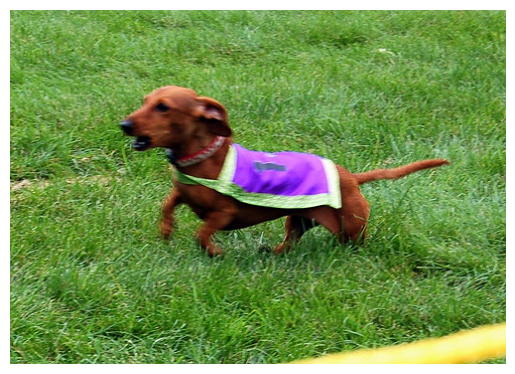

In [45]:
# Générer et afficher la caption pour l'image spécifiée
generate_caption("241046599_28b0ca7b9f.jpg")


In [46]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import numpy as np

# Validate with test data
actual, predicted = [], []

for key in tqdm(test):
    captions = mapping[key]

    # s'assurer que la feature a la bonne shape (1, 4096)
    image_feature = np.array(features[key])
    if image_feature.ndim == 1:
        image_feature = np.expand_dims(image_feature, axis=0)  # (1, 4096)
    elif image_feature.ndim == 2 and image_feature.shape[0] != 1:
        image_feature = image_feature[:1, :]  # prendre juste un batch

    # predict the caption for image
    y_pred = predict_caption(model, image_feature, tokenizer, max_length)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))  # Unigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))  # Bigram


100%|██████████| 810/810 [10:25<00:00,  1.29it/s]


BLEU-1: 0.475019
BLEU-2: 0.254914


In [51]:
import os
import pickle

# --- Sauvegarde du modèle au format HDF5 (.h5) ---
model_h5_path = os.path.join(working_dir, "model.h5")
model.save(model_h5_path)
print("✔️ Modèle sauvegardé au format .h5 dans :", model_h5_path)

# --- Sauvegarde du modèle au format natif Keras (.keras) ---
model_keras_path = os.path.join(working_dir, "model.keras")
model.save(model_keras_path)
print("✔️ Modèle sauvegardé au format .keras dans :", model_keras_path)

# --- Sauvegarde du tokenizer ---
tokenizer_path = os.path.join(working_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)
print("✔️ Tokenizer sauvegardé dans :", tokenizer_path)


✔️ Modèle sauvegardé au format .h5 dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/model.h5
✔️ Modèle sauvegardé au format .keras dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/model.keras
✔️ Tokenizer sauvegardé dans : /content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie/tokenizer.pkl


In [53]:
import pickle
from tensorflow.keras.models import load_model

# Chemins vers les fichiers sauvegardés
model_path = "model.keras"       # <- utiliser le format natif Keras
tokenizer_path = "tokenizer.pkl"

# Charger le modèle
model = load_model(model_path)

# Charger le tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Maintenant tu peux directement utiliser la fonction predict_caption
# Exemple :
# y_pred = predict_caption(model, image_feature, tokenizer, max_length)


ValueError: File not found: filepath=model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np

# Charger le modèle et le tokenizer
model = load_model("model.keras")        # ou ton model corrigé
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Charger les features extraites (VGG16 ou autre)
with open("features.pkl", "rb") as f:
    features = pickle.load(f)

# Exemple pour générer une caption
image_id = "1019077836_6fc9b15408"
image_feature = features[image_id]
caption = predict_caption(model, image_feature, tokenizer, max_length)
print(caption)


FileNotFoundError: [Errno 2] No such file or directory: 'features.pkl'

In [54]:
working_dir = '/content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie'

# Charger le modèle Keras natif
model_path = os.path.join(working_dir, "model.keras")  # fichier .keras sauvegardé
model = load_model(model_path)

# Charger le tokenizer
tokenizer_path = os.path.join(working_dir, "tokenizer.pkl")
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Charger les features si nécessaire
features_path = os.path.join(working_dir, "features.pkl")
with open(features_path, "rb") as f:
    features = pickle.load(f)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🖼️ Image: filledanslamer.jpeg
📝 Caption générée: startseq young girl wearing yellow bathing suit jumps into swimming pool endseq


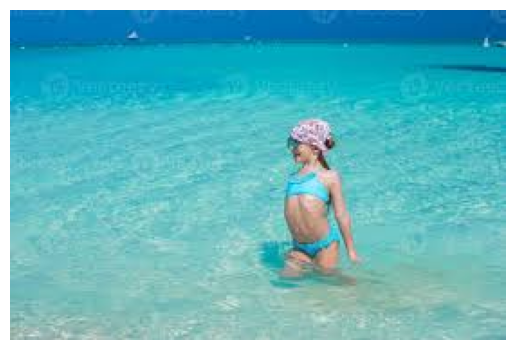

In [55]:
import os
import pickle
import numpy as np
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# Répertoires et fichiers
# -----------------------------
working_dir = '/content/gdrive/MyDrive/Imagetest/testpfaaveckaggle8kprojetcopie'
Base_dir = '/content/gdrive/MyDrive/Imagetest/imagedetest'  # dossier réel des images

model_path = os.path.join(working_dir, "model.keras")      # modèle Keras
tokenizer_path = os.path.join(working_dir, "tokenizer.pkl") # tokenizer

# -----------------------------
# Charger les fichiers
# -----------------------------
model = load_model(model_path)
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Longueur maximale des séquences
max_length = 34

# -----------------------------
# Créer VGG16 pour extraction des features
# -----------------------------
vgg_model = VGG16()
feature_extractor = Model(inputs=vgg_model.inputs, outputs=vgg_model.get_layer("fc2").output)

# -----------------------------
# Fonctions pour prédiction
# -----------------------------
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None

def extract_features(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = feature_extractor.predict(image, verbose=0)
    return feature

def predict_caption(model, image_feature, tokenizer, max_length):
    if len(image_feature.shape) != 2:
        image_feature = np.reshape(image_feature, (1, 4096))
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([image_feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

def find_image_file(image_name):
    """Cherche l’image dans le dossier Base_dir, insensible à la casse et aux extensions"""
    image_name_lower = image_name.lower()
    for file in os.listdir(Base_dir):
        if file.lower().startswith(os.path.splitext(image_name_lower)[0]):
            return os.path.join(Base_dir, file)
    return None

def generate_caption(image_name):
    # Chercher l'image dans le dossier
    img_path = find_image_file(image_name)
    if img_path is None:
        print(f"⚠️ Image non trouvée : {image_name}")
        return

    # Extraire les features
    features = extract_features(img_path)

    # Générer la caption
    y_pred = predict_caption(model, features, tokenizer, max_length)

    # Afficher l'image
    image = Image.open(img_path)
    print("🖼️ Image:", os.path.basename(img_path))
    print("📝 Caption générée:", y_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# -----------------------------
# Exemple d'utilisation
# -----------------------------
generate_caption("filledanslamer.jpeg")  # tu peux mettre "produit1" sans extension
